# Imports

In [204]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [206]:
import pycaret
# check version
from pycaret.utils import version
version()

2.0


In [207]:
#Import everything from PyCaret package for classification
from pycaret.classification import *

In [208]:
plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('float_format', '{:f}'.format)

# Modelling

This notebook assumes that you've followed the steps in `Propensity_Data_Prep` notebook or have your own data already prepared. Modelling in `PyCaret` in general is very experiment focused (as any DS project should be in the beginning). So you need to get used to the experimenting framework that it provides, luckily it's quite intuitive and easy to use. The Modelling process will consist out of the following steps:

1. Setup the experiment parameters which include
    * Data cleaning
    * Data transformation
    * Dimensionality reduction
    * and a lot more...(see the documentation)
2. Compare the available models and pick the best ones
3. Tune the models
4. Try Ensembles and Stacking
5. Evaluate
6. Save the model
7. Run another experiment until you are satisfied with the preformance


**Suggestion: Create 1 notebook per experiment** to not confuse the setup environments

## Experiment 1: Simple
In this experiment I'm going to use only the data about transactions and do only minimal pre-processing. This is a baseline setup to see what's the performance that I can expect.

In [210]:
data = pd.read_csv('./outputs/generated_data.csv')

In [211]:
data.head()

,customer_id,D7_SUM(transactions.coupon_discount),D7_SUM(transactions.other_discount),D7_SUM(transactions.quantity),D7_SUM(transactions.selling_price),D7_STD(transactions.coupon_discount),D7_STD(transactions.other_discount),D7_STD(transactions.quantity),D7_STD(transactions.selling_price),D7_MAX(transactions.coupon_discount),...,D56_MAX(transactions.selling_price),D56_SKEW(transactions.coupon_discount),D56_SKEW(transactions.other_discount),D56_SKEW(transactions.quantity),D56_SKEW(transactions.selling_price),D56_MIN(transactions.coupon_discount),D56_MIN(transactions.other_discount),D56_MIN(transactions.quantity),D56_MIN(transactions.selling_price),is_super
0,1,-53.420000,-368.660000,25.000000,1867.900000,6.693811,27.726490,0.288104,48.746850,0.000000,...,445.250000,-9.220279,-5.720998,3.861156,2.299973,-89.050000,-372.230000,1.000000,17.810000,0
1,1,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,...,445.250000,-9.748455,-5.303531,3.792618,2.513127,-89.050000,-372.230000,1.000000,17.810000,0
2,1,-14.250000,-387.200000,33.000000,2234.440000,2.794655,24.840580,0.533494,33.363350,0.000000,...,445.250000,-9.319856,-5.463633,3.624902,2.754597,-89.050000,-372.230000,1.000000,21.020000,0
3,1,0.000000,-312.030000,19.000000,1414.100000,0.000000,30.537487,0.235702,44.913198,0.000000,...,445.250000,-9.134769,-5.450776,3.751392,2.683371,-89.050000,-372.230000,1.000000,21.020000,0
4,1,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,...,445.250000,-9.134769,-5.450776,3.751392,2.683371,-89.050000,-372.230000,1.000000,21.020000,0


In [224]:
data.is_super.value_counts()

0    66741
1    14708
Name: is_super, dtype: int64

### Setup

The experiment setup is as follows:
1. Predict is_super column
2. Apply PCA to the input variables
3. Fix the class imbalance using SMOTE

In [212]:
data = data.drop('customer_id', axis=1)

In [225]:
clf1 = setup(data, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_pca',
             train_size=0.7,
             pca=True, 
             pca_components=0.95,
             numeric_features = ['D56_MIN(transactions.quantity)', 'D56_MAX(transactions.coupon_discount)', 'D49_MAX(transactions.coupon_discount)', 'D42_MAX(transactions.coupon_discount)', 'D35_MAX(transactions.coupon_discount)', 'D28_MAX(transactions.coupon_discount)' ],
             fix_imbalance=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(81449, 161)"
4,Missing Values,True
5,Numeric Features,160
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### Compare the models
Comparing the models is a one-line code command in PyCaret. Specify the metric that is the most important to you and the number of top models that you want to keep. 

In [226]:
top_models = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.7861,0.7272,0.5182,0.4247,0.4667,0.3346,0.3373,6.7342
1,Ada Boost Classifier,0.7799,0.7246,0.5250,0.4147,0.4628,0.3270,0.3309,2.6420
2,Light Gradient Boosting Machine,0.7929,0.7167,0.4959,0.4356,0.4636,0.3360,0.3372,1.5118
3,CatBoost Classifier,0.7935,0.7166,0.4910,0.4366,0.4621,0.3349,0.3358,55.2876
4,Linear Discriminant Analysis,0.7950,0.7161,0.5046,0.4414,0.4707,0.3443,0.3456,0.0244
5,Logistic Regression,0.7717,0.7138,0.5415,0.4022,0.4614,0.3206,0.3264,0.1116
6,Extreme Gradient Boosting,0.7936,0.7083,0.4798,0.4352,0.4563,0.3293,0.3300,5.3633
7,Extra Trees Classifier,0.8020,0.6902,0.4240,0.4491,0.4361,0.3161,0.3164,1.3198
8,Random Forest Classifier,0.8016,0.6856,0.3917,0.4440,0.4160,0.2971,0.2981,0.2848
9,Quadratic Discriminant Analysis,0.8146,0.6841,0.4301,0.4851,0.4558,0.3445,0.3455,0.0286


### Evaluate 

In [221]:
preds = predict_model(top_models[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.835900,0.723900,0.232900,0.621800,0.338800,0.266700,0.308900


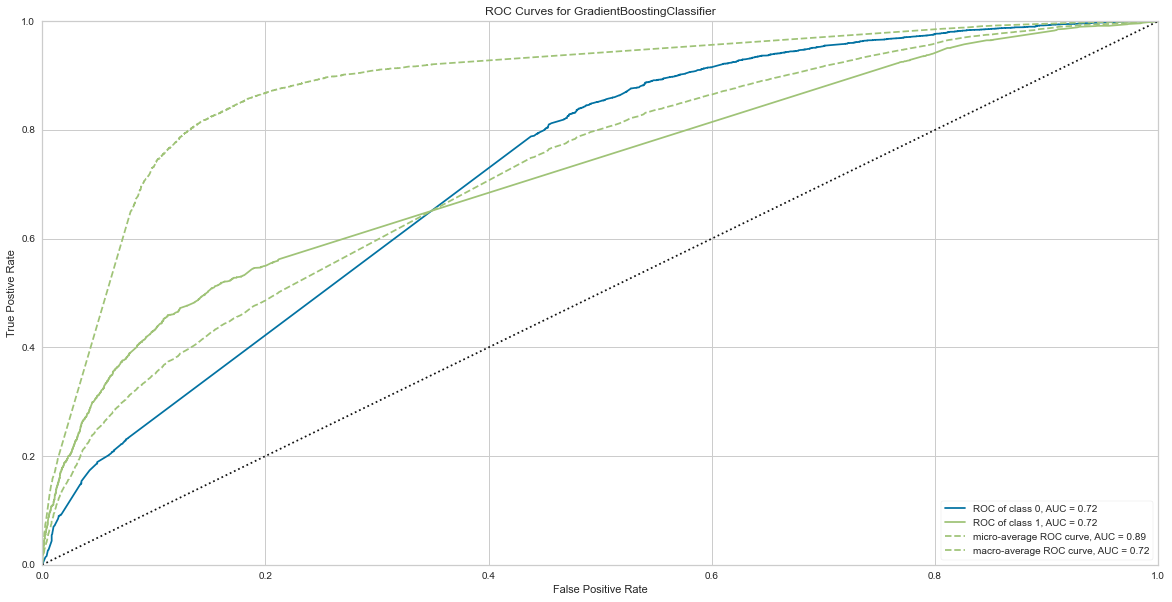

In [223]:
plot_model(top_models[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

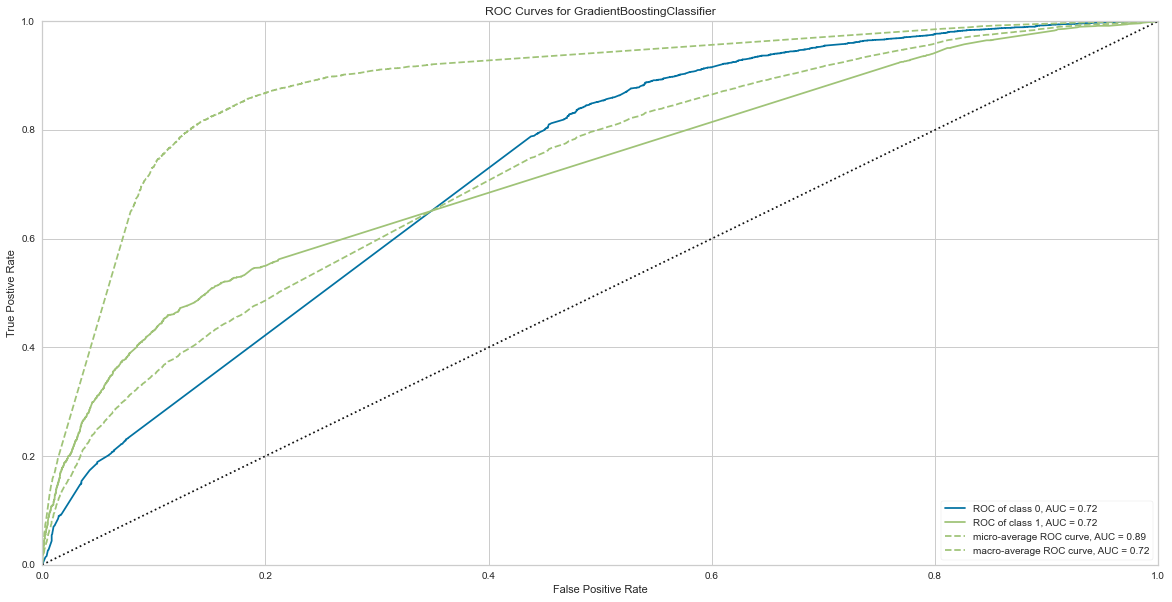

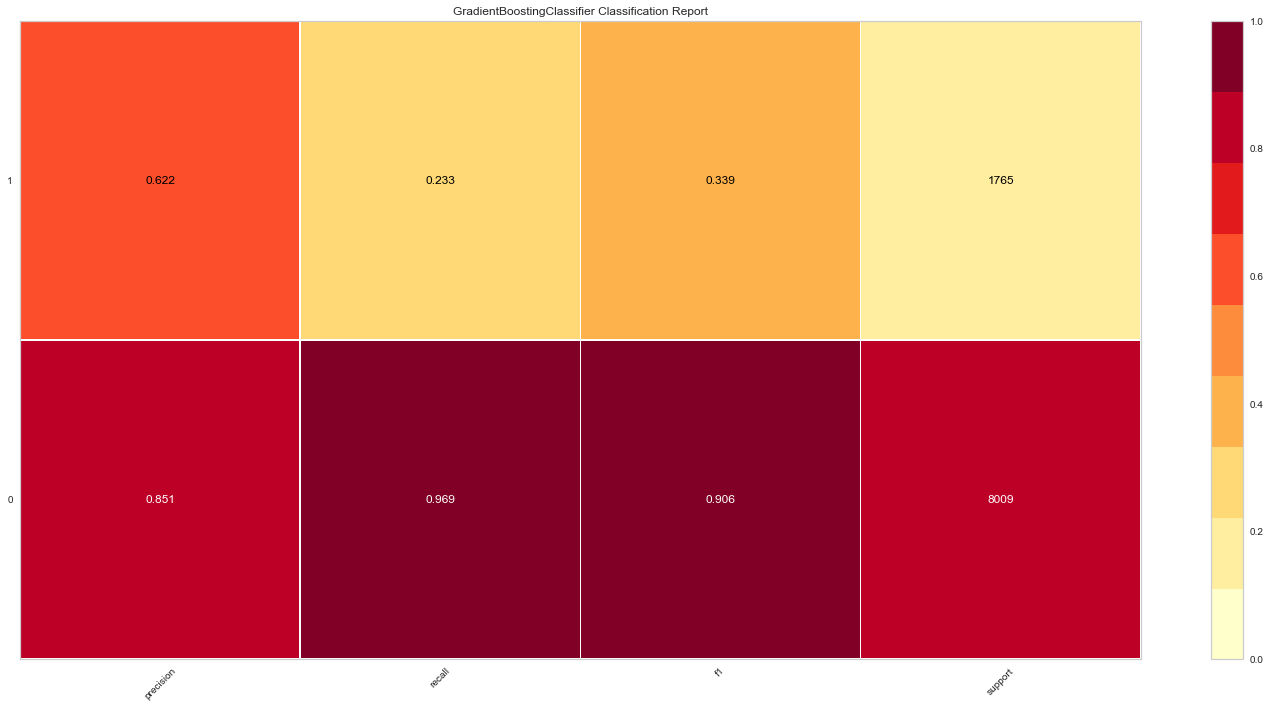

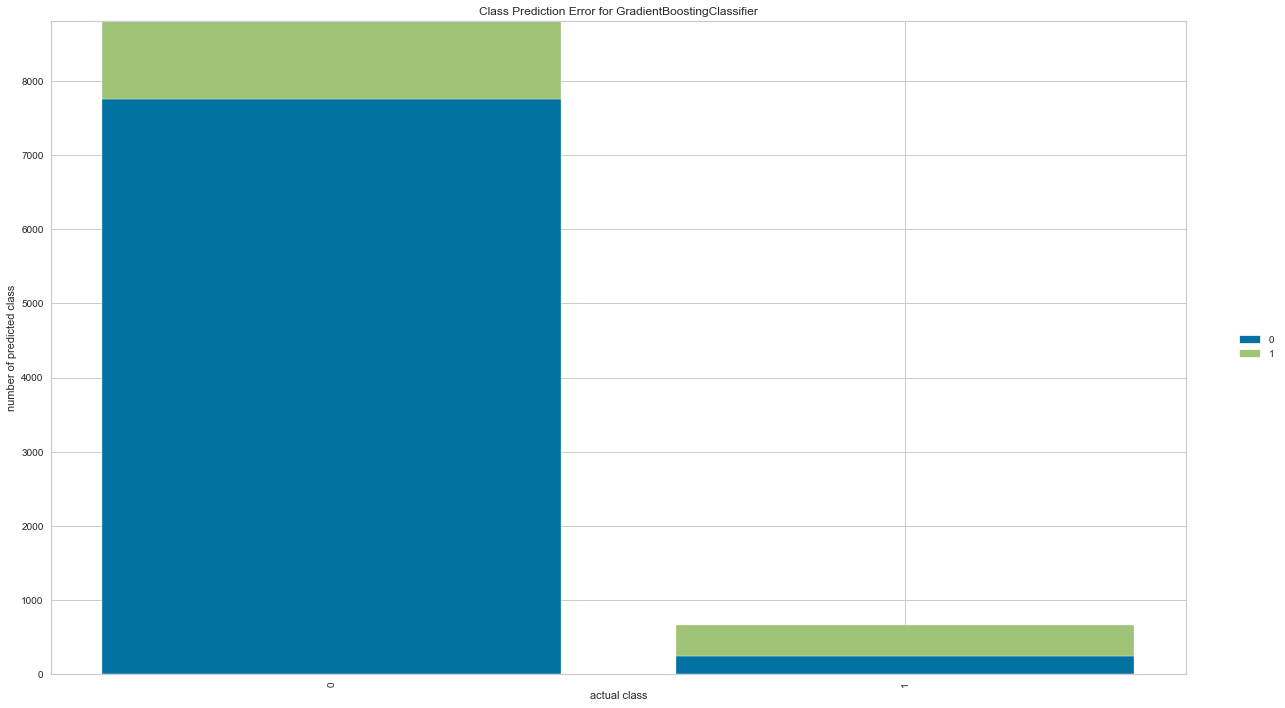

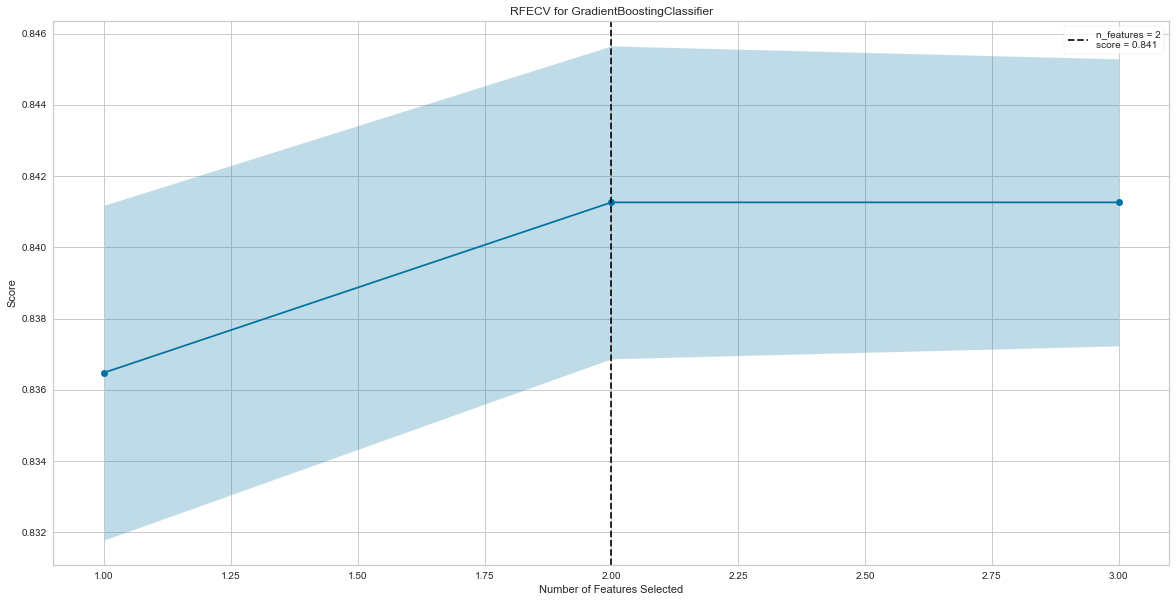

In [227]:
evaluate_model(top_models[0])

## Experiment 2: Advanced

In this more advanced experiment, I'm going to bring in the customers datasets to augment the transactional data.

In [112]:
data2 = pd.read_csv('./output/generated_data.csv')

In [125]:
customers = pd.read_csv('./data/customer_demographics.csv')

In [124]:
data_with_demo = data2.merge(customers, on='customer_id', how='left')
data_with_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81449 entries, 0 to 81448
Columns: 168 entries, customer_id to income_bracket
dtypes: float64(162), int64(2), object(4)
memory usage: 105.0+ MB


### Setup

Besides PCA and SMOTE, in this setup I'm also:
1. Applying normalisation 
2. Transforming the input features with Yeo-Johnson
3. Removing highly correlated features
4. Ignoring low variance features

In [129]:
clf2 = setup(data_with_demo, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_demo_pca',
             train_size=0.7, 
             normalize = True, 
             transformation = True, 
             ignore_low_variance = True,
             remove_multicollinearity = True, 
             multicollinearity_threshold = 0.95,
             categorical_features = ['marital_status', 'rented', 'family_size', 'no_of_children', 'age_range', 'income_bracket'], 
             pca=True, pca_components=0.95, 
             fix_imbalance=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(81449, 168)"
4,Missing Values,True
5,Numeric Features,155
6,Categorical Features,12
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### Compare the models

In [130]:
top_models2 = compare_models(sort='AUC', n_select=5, fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.7900,0.8096,0.5942,0.4401,0.5055,0.3760,0.3829,9.1418
1,Random Forest Classifier,0.7761,0.7907,0.5630,0.4124,0.4760,0.3380,0.3447,2.1013
2,K Neighbors Classifier,0.7090,0.7639,0.7136,0.3500,0.4696,0.3000,0.3362,1.4187
3,Light Gradient Boosting Machine,0.7865,0.7615,0.5519,0.4292,0.4828,0.3510,0.3554,1.5062
4,CatBoost Classifier,0.7958,0.7550,0.5355,0.4457,0.4865,0.3604,0.3628,35.8652
5,Extreme Gradient Boosting,0.7875,0.7547,0.5564,0.4317,0.4861,0.3548,0.3594,15.7431
6,Gradient Boosting Classifier,0.7864,0.7410,0.5047,0.4235,0.4605,0.3286,0.3306,85.1326
7,Logistic Regression,0.7855,0.7182,0.5078,0.4219,0.4608,0.3284,0.3306,0.6626
8,Linear Discriminant Analysis,0.7883,0.7173,0.5039,0.4271,0.4623,0.3316,0.3334,0.6691
9,Ada Boost Classifier,0.7752,0.7167,0.4972,0.4015,0.4441,0.3053,0.3081,17.9795


We can see already that the decision to include more data and do some input pre-processing have given a significant boost to the best model's AUC - **from 0.73 to 0.81**. Let's see if we can squeeze a bit more performance from these models by doing hyperparameter tuning.

### Hyperparameter Tuning

Hyperparameter tuning is also a one-line command in PyCaret. In the background it uses a Random Grid Search with pre-defined search space which is not the optimal strategy to use, but it is very easy and efficient. Important parameters to consider:
* **n_iter** - default is 10, but if you have time set it to 50-100
* **custom_grid** - if you know what you are doing, provide your own grid
* **optimize** - metric to optimise, by default Accuracy in classification. Set it to AUC for binary or F1 for multi-class
* **choose_better** - will replace a model only if found a better model. By default is False, but set it to True. 

In [131]:
#Tuning single model
tuned_extra = tune_model(top_models2[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7895,0.8135,0.6214,0.4414,0.5161,0.3865,0.3958
1,0.7962,0.8178,0.6019,0.4519,0.5162,0.3905,0.3969
2,0.7862,0.8100,0.6019,0.4339,0.5043,0.3725,0.3806
3,0.7922,0.8067,0.5932,0.4437,0.5077,0.3794,0.3859
4,0.7844,0.8080,0.5928,0.4296,0.4982,0.3653,0.3730
5,0.7869,0.8106,0.5850,0.4331,0.4977,0.3663,0.3729
6,0.8086,0.8197,0.6084,0.4764,0.5344,0.4162,0.4211
7,0.7820,0.8074,0.5831,0.4243,0.4912,0.3568,0.3641
8,0.7935,0.8145,0.6107,0.4477,0.5166,0.3893,0.3969
9,0.7842,0.8003,0.5845,0.4288,0.4947,0.3616,0.3686


In [133]:
#Tuneing all 5 best models
tuned_best = [tune_model(m) for m in top_models2]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7920,0.7454,0.5117,0.4355,0.4705,0.3422,0.3439
1,0.7959,0.7479,0.5039,0.4428,0.4714,0.3455,0.3467
2,0.7857,0.7308,0.4903,0.4201,0.4525,0.3203,0.3217
3,0.7853,0.7306,0.4864,0.4189,0.4501,0.3177,0.3191
4,0.7816,0.7365,0.4908,0.4119,0.4479,0.3131,0.3149
5,0.7879,0.7346,0.4849,0.4236,0.4522,0.3215,0.3226
6,0.7874,0.7400,0.5053,0.4252,0.4618,0.3306,0.3325
7,0.7878,0.7322,0.4898,0.4239,0.4545,0.3236,0.3249
8,0.7895,0.7445,0.5126,0.4307,0.4681,0.3381,0.3401
9,0.7832,0.7310,0.4981,0.4164,0.4536,0.3197,0.3217


The individual models are tuned now, so let's try them in the ensemble model

### Ensemble Model

We can do ensebmle modelling using the `blend_models` method in PyCaret. It simply takes the outputs of all the input models and creates a soft (with probability) or hard (0 or 1) voting classifier. If majority of models vote yes, the example is considered as positive, and vice versa. 

In [136]:
blended = blend_models(estimator_list = tuned_best[:4], method = 'soft') #doesn't take catboost yet

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7753,0.8197,0.6728,0.4233,0.5197,0.3828,0.4003
1,0.7836,0.8268,0.6650,0.4352,0.5261,0.3937,0.4086
2,0.7762,0.8176,0.6534,0.4227,0.5133,0.3766,0.3917
3,0.7780,0.8128,0.6650,0.4265,0.5197,0.3842,0.4002
4,0.7762,0.8152,0.6589,0.4230,0.5152,0.3786,0.3943
5,0.7793,0.8160,0.6638,0.4282,0.5206,0.3858,0.4014
6,0.7906,0.8249,0.6628,0.4460,0.5332,0.4048,0.4180
7,0.7716,0.8157,0.6540,0.4157,0.5083,0.3691,0.3851
8,0.7828,0.8215,0.6845,0.4357,0.5325,0.4000,0.4173
9,0.7774,0.8048,0.6631,0.4255,0.5184,0.3825,0.3984


As we can see, we've achieved an increse in AUC from 0.8096 to 0.8175 just by running 2 lines of code. It's not a huge increase, but can be important in the real-life scenario. 

### Evaluation

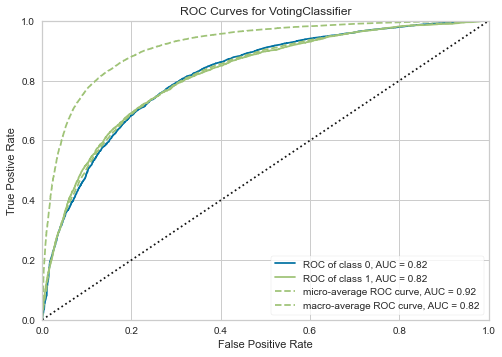

In [141]:
plot_model(blended)

The holdout AUC is 0.82 so it has generalised well from the training set. From the graph we can pick the acceptable level of True Positive and see the corresponding rate of False Positives. 

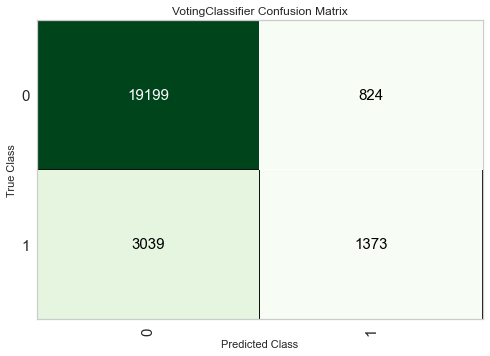

In [140]:
plot_model(blended, plot='confusion_matrix')

Seems like the default threshold (0.5) is too high since most of the super-customers are missed. Let's adjust it manually and see the new confusion matrix.

In [197]:
#Hold out predictions
holdout_predict = predict_model(blended, probability_threshold = 0.25) #set new threshold

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.804000,0.820100,0.639800,0.468600,0.541000,0.420100,0.428400


In [198]:
print(holdout_predict.shape)
holdout_predict.head()

(24435, 41)


,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_32,Component_33,Component_34,Component_35,Component_36,Component_37,Component_38,is_super,Label,Score
0,-2.544764,-2.328525,-0.078242,-0.115714,-0.585760,-0.081028,0.108553,0.043515,0.023046,-0.223057,...,0.018259,-0.031879,-0.006517,-0.008464,0.003500,0.003364,-0.003302,0,0,0.017200
1,3.029362,-1.804538,1.272870,0.070469,2.111477,-0.559765,-0.056619,-0.751619,-1.888457,1.709214,...,-0.373034,-0.200288,0.201164,0.256178,0.362285,0.155078,0.378692,0,0,0.083600
2,-2.550096,-2.328197,-0.080079,-0.114734,-0.584198,-0.081684,0.105298,0.039235,0.015759,-0.213136,...,0.018843,-0.033405,-0.006082,-0.010528,0.002739,0.001843,-0.003721,1,0,0.182800
3,8.688579,1.194962,-1.231271,-0.737514,-0.391022,-1.767161,0.119314,1.523476,-0.914976,1.005851,...,0.215981,0.487701,2.153599,1.189450,-0.245479,0.975287,-1.290036,0,0,0.161400
4,-2.532143,-2.329302,-0.073893,-0.118033,-0.589457,-0.079475,0.116258,0.053648,0.040294,-0.246542,...,0.016877,-0.028269,-0.007547,-0.003579,0.005303,0.006965,-0.002310,0,0,0.019700


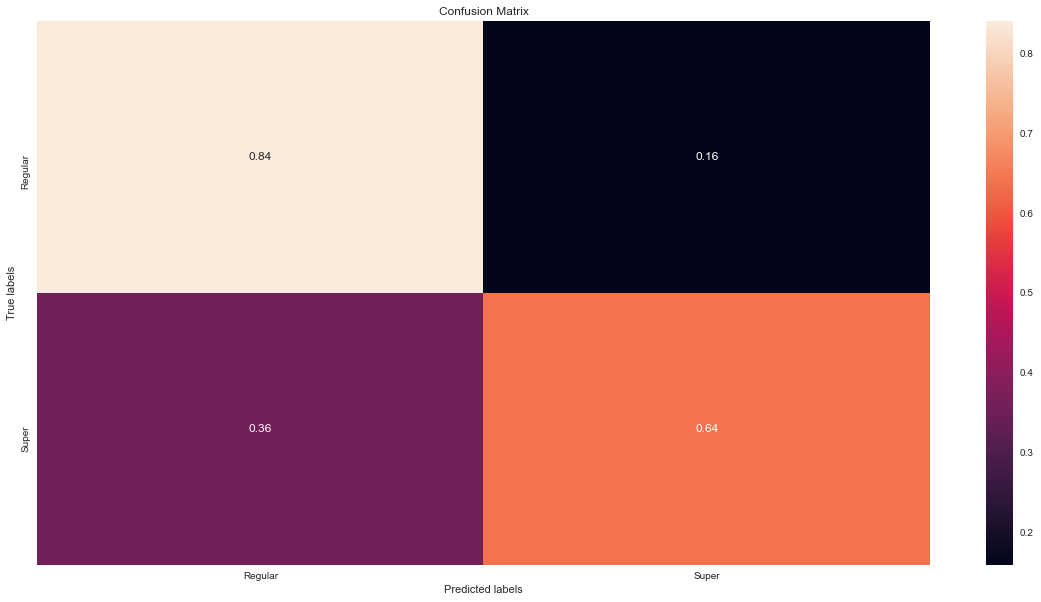

In [199]:
labels = [0,1]
cm = confusion_matrix(holdout_predict['is_super'], holdout_predict['Label'], labels, normalize='true')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Regular', 'Super']); ax.yaxis.set_ticklabels(['Regular', 'Super']);

## Deployment

This step is not strictly speaking deployment, but we're saving the model for later use. Notice, that it's not only the model that gets saved, but also the entire pre-processing pipeline. This allows your results to be replicable. 

In [201]:
#retrains on the entire data
final_model = finalize_model(blended)

In [202]:
#saving
save_model(final_model,'Final Blend Model 12Aug2020')

Transformation Pipeline and Model Succesfully Saved
